In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, NumbaPerformanceWarning
import cv2
import os
from numba.typed import List

from plot_helpers import plotCoordinateFrame, set_axes_equal
from jacobian import jac
from manifold import K_from_vec, vec_from_K, SO3_from_vec, SE3_from_vec, vec_from_SE3, skew
from optimize import levenberg_marquardt

import warnings
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)
np.set_printoptions(suppress=True, precision=3, edgeitems=30, linewidth=100000)

In [2]:
#----------- Projection helpers ----------#
@njit
def h(K, T, P):
    p_homo = K@T@to_homogen(P).T
    return from_homogen(p_homo.T)

@njit
def to_homogen(p):
    return np.hstack(( p, np.ones((p.shape[0], 1)) ))

@njit
def from_homogen(p):
    p /= p[:,-1:]
    return p[:,:-1]

@njit
def residuals(K, Ts, Ps, zs):     
    # Compute expected measurements
    steps = [0] + [cam_meas[0].shape[0] for cam_meas in zs]
    steps = np.cumsum(np.array(steps))
    res = np.zeros(2*steps[-1])

    for cam_idx, (pt_idx, meas) in enumerate(zs):
        p_prime = h(K, Ts[cam_idx], Ps[pt_idx])
        res[2*steps[cam_idx]:2*steps[cam_idx+1]] = (meas - p_prime).flatten()
    
    return res

### Match points

In [3]:
def read_image(filename, scale):
    # load images
    im = cv2.imread(filename)

    width = int(im.shape[1] * scale / 100)
    height = int(im.shape[0] * scale / 100)
    dim = (width, height)

    # resize image
    im = cv2.resize(im, dim, interpolation = cv2.INTER_AREA)
    return im

# There was a bunch of bugs in the original implementation...
def plotMatches(im1, im2, locs1, locs2, filename=None):
    fig = plt.figure()
    # draw two images side by side
    imH = max(im1.shape[0], im2.shape[0])
    im = np.zeros((imH, im1.shape[1]+im2.shape[1]), dtype='uint8')
    
    if len(im1.shape) >= 3:
        im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    if len(im2.shape) >= 3:
        im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
        
    im[0:im1.shape[0], 0:im1.shape[1]] = im1
    im[0:im2.shape[0], im1.shape[1]:] = im2
    
    plt.imshow(im, cmap='gray')
    for ((x1, y1), (x2, y2)) in zip(locs1, locs2):
        plt.plot([x1, x2+im1.shape[1]], [y1,y2], 'r', lw=0.5)

    plt.show()
    
def sevenpoint(pts1, pts2, M):
    '''
    Q1.2: Seven Point Algorithm for calculating the fundamental matrix
        Input:  pts1, 7x2 Matrix containing the corresponding points from image1
                pts2, 7x2 Matrix containing the corresponding points from image2
                M, a scalar parameter computed as max (imwidth, imheight)
        Output: Farray, a list of estimated 3x3 fundamental matrixes.
    '''
    Farray = []

    # Computing the 3x3 matrix used to normalize corresponding points. 
    T = np.diag([1/M,1/M,1])
    
    # Scale our points
    pts1 = pts1@T[:2,:2]
    pts2 = pts2@T[:2,:2]
    x1, y1 = pts1.T
    x2, y2 = pts2.T
    ones = np.ones_like(x2)
    
    # Create our matrices
    A = np.column_stack((x1*x2, x1*y2, x1, y1*x2, y1*y2, y1, x2, y2, ones))
    
    # Use SVD to extract F
    U, S, VT = np.linalg.svd(A)
    Fs = np.array([VT[-1].reshape((3,3)).T, VT[-2].reshape((3,3)).T])
    
    # Solve cubic
    D = np.zeros((2,2,2))
    for i1 in range(2):
        for i2 in range(2):
            for i3 in range(2):
                temp = np.zeros((3,3))
                temp[:,0] = Fs[i1,0]
                temp[:,1] = Fs[i2,1]
                temp[:,2] = Fs[i3,2]
                D[i1,i2,i3] = np.linalg.det(temp)
                
    coeff = np.zeros(4)
    coeff[0] = -D[1][0][0]+D[0][1][1]+D[0][0][0]+D[1][1][0]+D[1][0][1]-D[0][1][0]-D[0][0][1]-D[1][1][1];
    coeff[1] = D[0][0][1]-2*D[0][1][1]-2*D[1][0][1]+D[1][0][0]-2*D[1][1][0]+D[0][1][0]+3*D[1][1][1];
    coeff[2] = D[1][1][0]+D[0][1][1]+D[1][0][1]-3*D[1][1][1];
    coeff[3] = D[1][1][1];

    roots = np.polynomial.polynomial.polyroots(coeff[::-1])
    for r in roots:
        if np.isreal(r):
            a = np.real(r)
            F = Fs[0]*a + (1-a)*Fs[1]
            # Clean up matrix
            F = T.T@F@T
            F = F/F[2,2]
            Farray.append( F )
    
    return Farray    

def calc_epi_error(pts1_homo, pts2_homo, F):
    '''
    Helper function to calculate the sum of squared distance between the corresponding points and the estimated epipolar lines. 
    Expect pts1 and pts2 are in homogeneous coordinates and not normalized. 
    '''
    line1s = pts1_homo.dot(F.T)
    dist1 = np.square(np.divide(np.sum(np.multiply(
        line1s, pts2_homo), axis=1), np.linalg.norm(line1s[:, :2], axis=1)))

    line2s = pts2_homo.dot(F)
    dist2 = np.square(np.divide(np.sum(np.multiply(
        line2s, pts1_homo), axis=1), np.linalg.norm(line2s[:, :2], axis=1)))

    ress = (dist1 + dist2).flatten()
    return ress

def ransacF(pts1, pts2, M, max_iter=1000, tol=2):
    '''
    Q3.1: RANSAC method.
        Input:  pts1, Nx2 Matrix
                pts2, Nx2 Matrix
                M, a scaler parameter
        Output: F, the fundamental matrix
                inlier_curr, Nx1 bool vector set to true for inliers
    '''
    N = pts1.shape[0]
    pts1_homo, pts2_homo = to_homogen(pts1), to_homogen(pts2)
    inlier_curr = np.zeros(pts1.shape[0])
    
    # ----- TODO -----
    for i in range(max_iter):
        # Find H from random sample
        idx = np.random.randint(0, N, 7)
        Fs = sevenpoint(pts1[idx], pts2[idx], M)
        
        for F_prop in Fs:
            err = calc_epi_error(pts1_homo, pts2_homo, F_prop)
            inl = err < tol
            if np.sum(inl) > np.sum(inlier_curr):
                inlier_curr = inl
                F = F_prop
                
    return F, inlier_curr

def poses_from_E(E):
    # Decompose to find pose options
    U,S,V = np.linalg.svd(E)
    W = np.array([[0,-1,0], [1,0,0], [0,0,1]])

    # Make sure we have the right size
    if np.linalg.det(U.dot(W).dot(V))<0:
        W = -W

    # Make all possible options
    M2s = np.zeros([3,4,4])
    M2s[:,:,0] = np.concatenate([U.dot(W).dot(V), U[:,2].reshape([-1, 1])/abs(U[:,2]).max()], axis=1)
    M2s[:,:,1] = np.concatenate([U.dot(W).dot(V), -U[:,2].reshape([-1, 1])/abs(U[:,2]).max()], axis=1)
    M2s[:,:,2] = np.concatenate([U.dot(W.T).dot(V), U[:,2].reshape([-1, 1])/abs(U[:,2]).max()], axis=1)
    M2s[:,:,3] = np.concatenate([U.dot(W.T).dot(V), -U[:,2].reshape([-1, 1])/abs(U[:,2]).max()], axis=1)
    return M2s

def E_from_FK(F, K):
     # First find the essential matrix
    E = K.T@F@K
    
    # Enforce rank 2
    U,S,V = np.linalg.svd(E)
    m = S[:2].mean()
    E = U.dot(np.array([[m,0,0], [0,m,0], [0,0,0]])).dot(V)
    
    return E

def triangulate(C1, pts1, C2, pts2):
    '''
    Q2.2: Triangulate a set of 2D coordinates in the image to a set of 3D points.
        Input:  C1, the 3x4 camera matrix
                pts1, the Nx2 matrix with the 2D image coordinates per row
                C2, the 3x4 camera matrix
                pts2, the Nx2 matrix with the 2D image coordinates per row
        Output: P, the Nx3 matrix with the corresponding 3D points per row
                err, the reprojection error.
    
    ***
    Hints:
    (1) For every input point, form A using the corresponding points from pts1 & pts2 and C1 & C2
    (2) Solve for the least square solution using np.linalg.svd
    (3) Calculate the reprojection error using the calculated 3D points and C1 & C2 (do not forget to convert from 
        homogeneous coordinates to non-homogeneous ones)
    (4) Keep track of the 3D points and projection error, and continue to next point 
    (5) You do not need to follow the exact procedure above. 
    '''
    # ----- TODO -----
    p11, p12, p13 = C1
    p21, p22, p23 = C2
    N = pts1.shape[0]
    
    err = 0
    Pest = np.zeros((N,3))
    for i, ((x1, y1), (x2,y2)) in enumerate(zip(pts1, pts2)):
        # Get homogenous point
        A = np.vstack((
                        y1*p13 -    p12, 
                           p11 - x1*p13,
                        y2*p23 -    p22,
                           p21 - x2*p23
                ))
        
        U, S, VT = np.linalg.svd(A)
        Pi = VT[-1]
        Pi /= Pi[-1]
        
        # Compute reprojection err
        reproj_1 = C1@Pi
        reproj_2 = C2@Pi
        reproj_1 /= reproj_1[-1]
        reproj_2 /= reproj_2[-1]

        err += np.sum( (reproj_1[:2] - [x1,y1])**2 ) + np.sum( (reproj_2[:2] - [x2,y2])**2 ) #+ np.linalg.norm(X)/10
        Pest[i] = Pi[:3]
        
    return Pest, err
    

def pose_from_E(E, pts1, pts2, K):
    '''
    Q2.2: Function to find the camera2's projective matrix given correspondences
        Input:  F, the pre-computed fundamental matrix
                pts1, the Nx2 matrix with the 2D image coordinates per row
                pts2, the Nx2 matrix with the 2D image coordinates per row
                intrinsics, the intrinsics of the cameras, load from the .npz file
        Output: [M2, C2, P] the computed M2 (3x4) camera projective matrix, C2 (3x4) K2 * M2, and the 3D points P (Nx3)
    '''

    M1 = np.hstack((np.identity(3), np.zeros(3)[:,np.newaxis]))
    C1 = K@M1
    M2s = poses_from_E(E)
    best_error = np.finfo('float').max
    
    # Find which M is best
    for i in range(M2s.shape[-1]):
        Mi = M2s[:,:,i]
        Ci = K@Mi
        Pi, err = triangulate(C1, pts1, Ci, pts2)
        
        if err < best_error and np.all(Pi[:,2] >= 0):
            best_error = err
            M2best = Mi
            C2best = Ci
            P_best = Pi
            
    M2best = np.vstack((M2best, [[0,0,0,1]]))
    
    # print(f"Best Error {best_error}")
    return M2best, P_best

def find_kp(im):
    # Initiate SIFT detector
    feat = cv2.SIFT_create()
    # feat = cv2.ORB_create()
    
    # find the keypoints and descriptors with SIFT
    kp, des = feat.detectAndCompute(im,None)
    kp = np.array([k.pt for k in kp])
    return kp, des

In [10]:
%matplotlib inline 

K_init = np.array([[3271.7198,    0.,     1539.6885, 0],
             [   0.,     3279.7956, 2027.496, 0],
             [   0.,        0.,        1.,0    ]])

scale_percent = 25 # percent of original size
K_init[:2] *= scale_percent/100

folder = "data/statue"
valid_imgs = [".jpg", ".png"]
images = [os.path.join(folder, f) for f in sorted(os.listdir(folder)) if os.path.splitext(f)[1].lower() in valid_imgs]

# Take this out later, only try on some images so far
images = images[0:2]

# Get started with first image
im1 = read_image(images[0], scale_percent)
kp1, des1 = find_kp(im1)

Ts_init = np.zeros((len(images), 4, 4))
Ts_init[0] = np.eye(4)
Ps_init = np.zeros((0,3))
Ps_color = []

zs = [[] for _ in images]
last_kp_idxs = {} # maps kp index to lm index
lm_num = 0

# Iterate through all images
for i, file in enumerate(images[1:]):
    im2 = read_image(file, scale_percent)
    kp2, des2 = find_kp(im2)

    # BFMatcher with default params
    bf = cv2.BFMatcher(crossCheck=True)
    good_match = []
    knn_matches = bf.match(des1, des2)
    knn_matches = sorted(knn_matches, key = lambda x:x.distance)

    # Start going through matches
    match_idx = np.array([[m.queryIdx, m.trainIdx] for m in knn_matches])
    kp1_match = kp1[match_idx[:,0]]
    kp2_match = kp2[match_idx[:,1]]
    print(kp1_match.shape[0], "Starting # matches")
    
    # Ransac & find essential matrix
    E, inlier = cv2.findEssentialMat(kp1_match, kp2_match, K_init[:3,:3], method=cv2.RANSAC, threshold=1.5, prob=0.99)
    inlier = inlier.flatten().astype('bool')
    kp1_match = kp1_match[inlier]
    kp2_match = kp2_match[inlier]
    match_idx = match_idx[inlier]  
    print(kp1_match.shape[0], "After Essential matrix RANSAC")
    
    # Sort into seen before & not seen landmarks
    temp = set(last_kp_idxs.keys())
    seen_before = np.array([m in temp for m in match_idx[:,0]])
    kp1_idx_seen_before = match_idx[seen_before,0]

    # If we see a bunch of landmarks again, use those to find pose estimate
    if np.sum(seen_before) > 20:
        print(np.sum(seen_before), "Seen landmarks before")
        # Convert kp idx -> landmark index -> 3d point
        lm_seen = np.zeros_like(kp1_idx_seen_before)
        for k, idx in enumerate(kp1_idx_seen_before):
            lm_seen[k] = last_kp_idxs[idx]
        Ps_seen = Ps_init[lm_seen]
        
        # Use the estimating point estimates to find relative pose
        retval, rvec, tvec, inliers = cv2.solvePnPRansac(Ps_seen, kp2_match[seen_before], K_init[:3,:3], None, reprojectionError=20, confidence=.90)
        inliers = inliers.flatten()
        T = np.eye(4)
        T[:3,:3] = SO3_from_vec(rvec.flatten())
        T[:3,3] = tvec.flatten()
        # T = np.linalg.inv(T)
        Ts_init[i+1] = T
        print(kp1_match[seen_before][inliers].shape[0], "RANSAC after reprojection")
        print(T)

        zs[ i ].append((lm_seen[inliers], kp1_match[seen_before][inliers]))
        zs[i+1].append((lm_seen[inliers], kp2_match[seen_before][inliers]))
        last_kp_idxs = dict( zip(match_idx[seen_before,1][inliers], lm_seen[inliers]) )
        
        # Triangulate all the other ones
        Ps_new = cv2.triangulatePoints(K_init@Ts_init[i], K_init@T, kp1_match[~seen_before].T, kp2_match[~seen_before].T).T
        Ps_new = from_homogen(Ps_new)
        bad_pts = np.logical_or(Ps_new[:,2] < 0, np.linalg.norm(Ps_new,axis=1) > 50)
        
        # Update all vars
        lm_new = np.arange(Ps_init.shape[0], Ps_init.shape[0]+Ps_new[~bad_pts].shape[0])
        Ps_init = np.vstack((Ps_init, Ps_new[~bad_pts]))
        zs[ i ].append((lm_new, kp1_match[~seen_before][~bad_pts]))
        zs[i+1].append((lm_new, kp2_match[~seen_before][~bad_pts]))
        
        last_kp_idxs |= dict( zip(match_idx[~seen_before,1], lm_new) )
        
    # Otherwise create and use essential matrix
    elif np.sum(seen_before) == 0:
        print("Haven't seen much, using essential matrix")
        # recover pose
        points, R, t, inlier = cv2.recoverPose(E, kp1_match, kp2_match, K_init[:3,:3])
        T = np.eye(4)
        T[:3,:3] = R
        T[:3,3] = t.flatten()
        # T = np.linalg.inv(T)
        inlier = inlier.flatten() != 0
        kp1_match = kp1_match[inlier]
        kp2_match = kp2_match[inlier]
        match_idx = match_idx[inlier]  
        print(T)
    
        # Triangulate points
        Ps_new = cv2.triangulatePoints(K_init, K_init@T, kp1_match.T, kp2_match.T).T
        Ps_new /= Ps_new[:,3:]

        # Gives relative pose of frame i+1 wrt frame i
        # Transform into global coordinates
        Ts_init[i+1] = Ts_init[i]@T
        Ps_new = from_homogen( (Ts_init[i]@Ps_new.T).T )
        
        # Update vars
        lm_new = np.arange(Ps_init.shape[0], Ps_init.shape[0]+Ps_new.shape[0])
        Ps_init = np.vstack((Ps_init, Ps_new))
        zs[ i ].append((lm_new, kp1_match))
        zs[i+1].append((lm_new, kp2_match))
        last_kp_idxs = dict( zip(match_idx[:,1], lm_new) )
        
        #  colors = [
        #     im1[ tuple(np.round(k_1[::-1]).astype('int')) ],
        #     im2[ tuple(np.round(k_2[::-1]).astype('int')) ],
        # ]
        
    else:
        print("Got between 0 and 20 matches seen before, not sure what to do!")
    
    # Prep for next iteration
    kp1 = kp2
    des1 = des2
    im1 = im2
    print()

zs = [tuple(zip(*meas)) for meas in zs]
# zs = List((np.concatenate(m), np.vstack(n)) for m,n in zs)
# Ps_color = np.array([np.mean(m, axis=0).astype('uint8') for m in Ps_color]) / 255
# Ps_color[:,[0,2]] = Ps_color[:,[2,0]]
# plotMatches(im1, im2, kp1_match, kp2_match)

2320 Starting # matches
1645 After Essential matrix RANSAC
Haven't seen much, using essential matrix
[[ 0.991 -0.012  0.135 -1.   ]
 [ 0.011  1.     0.014  0.027]
 [-0.135 -0.013  0.991 -0.012]
 [ 0.     0.     0.     1.   ]]



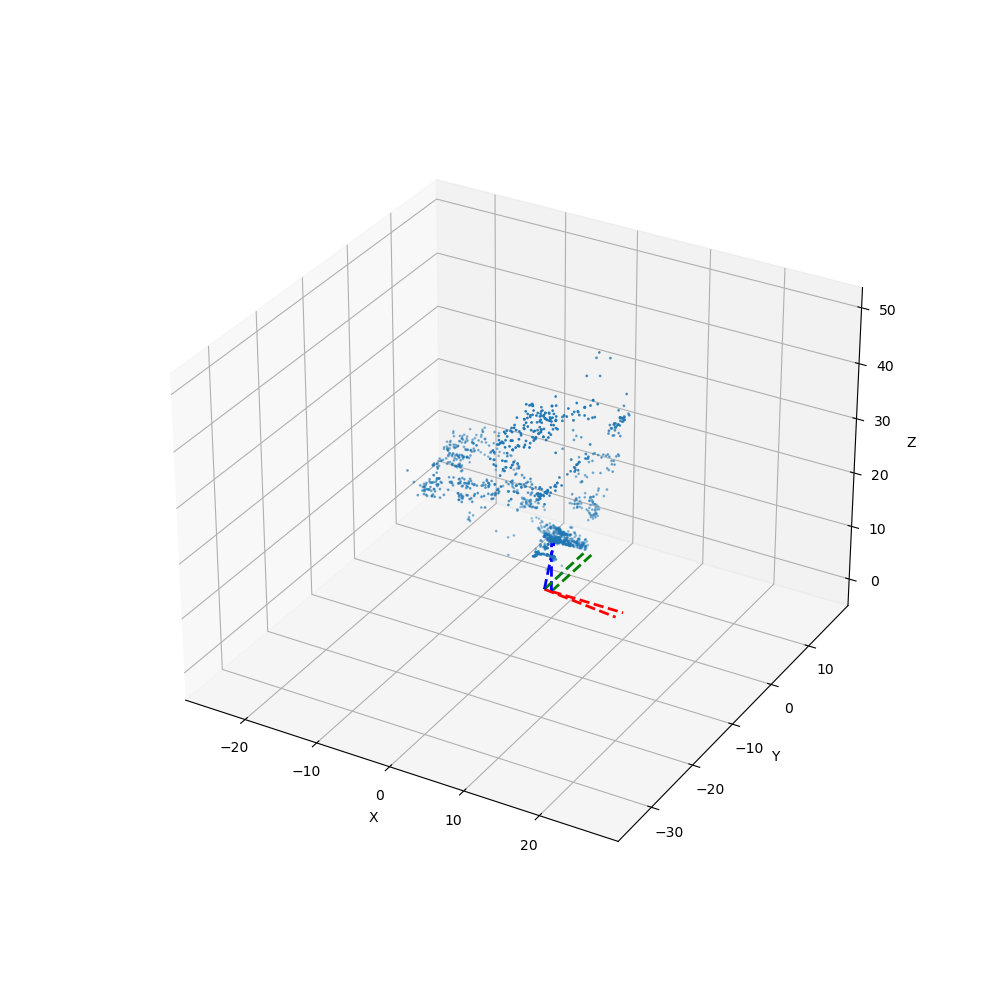

In [11]:
%matplotlib widget
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

for T in Ts_init:
    plotCoordinateFrame(T, ax=ax, k="--", size=10)
ax.scatter(Ps_init[:,0], Ps_init[:,1], Ps_init[:,2], s=1)

set_axes_equal(ax)
ax.set_zlabel("Z")
ax.set_ylabel("Y")
ax.set_xlabel("X")
# ax.view_init(-44, 81)
plt.show()

### Run Optimizer

In [9]:
print(np.linalg.norm(residuals(K_init, Ts_init, Ps_init, zs))**2)
K_result, Ts_result, Ps_result = levenberg_marquardt(residuals, K_init, Ts_init, Ps_init, zs, jac, max_iters=100, lam=0.01, lam_multiplier=2, tol=1e-4, verbose=True)
print(np.linalg.norm(residuals(K_result, Ts_result, Ps_result, zs))**2)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Unknown attribute 'shape' of type UniTuple(array(int64, 1d, C) x 1)

File "../../../../tmp/ipykernel_2113339/3979725063.py", line 19:
<source missing, REPL/exec in use?>

During: typing of get attribute at /tmp/ipykernel_2113339/3979725063.py (19)

File "../../../../tmp/ipykernel_2113339/3979725063.py", line 19:
<source missing, REPL/exec in use?>


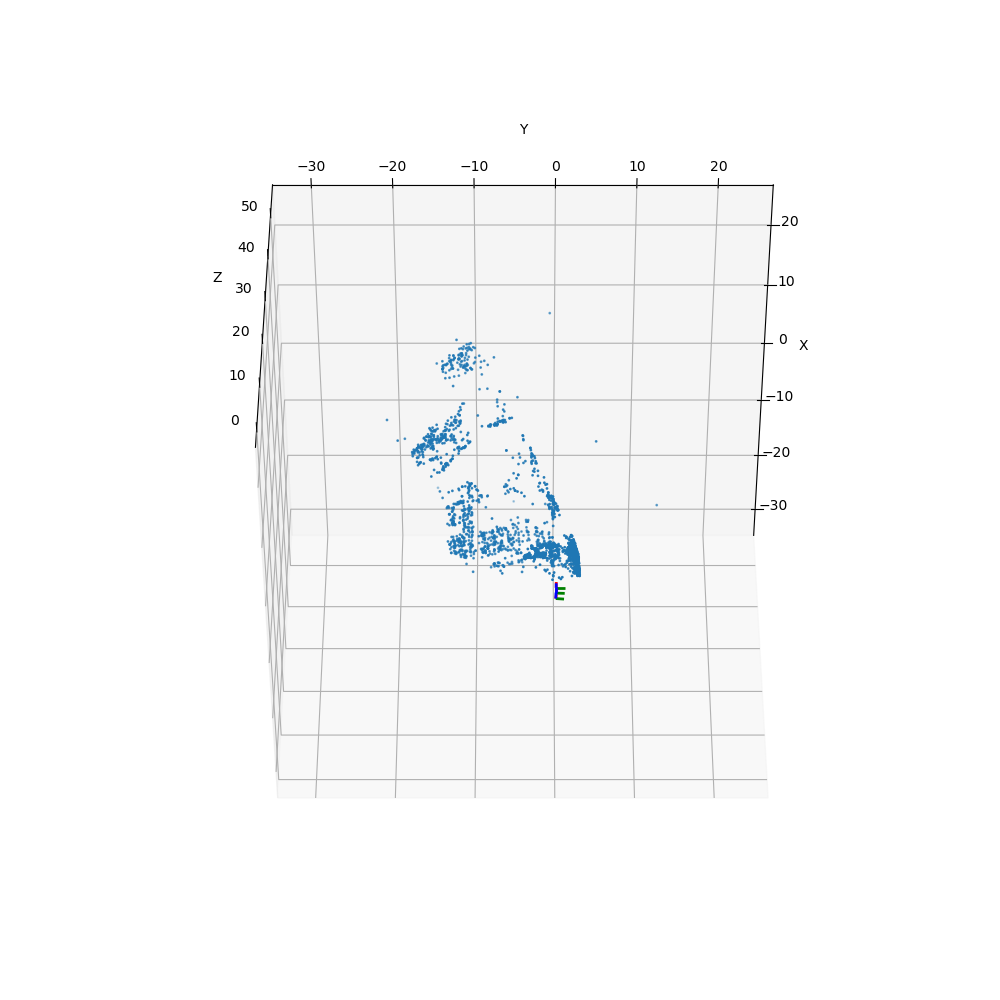

In [55]:
%matplotlib widget
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Ps_result[:,0], Ps_result[:,1], Ps_result[:,2], s=1)
for T in Ts_result:
    plotCoordinateFrame(T, ax=ax, k="--", size=1)
set_axes_equal(ax)
ax.set_zlabel("Z")
ax.set_ylabel("Y")
ax.set_xlabel("X")
ax.view_init(-45, 0)
plt.show()